# Modules

In [68]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import os
import subprocess

os.chdir(subprocess.check_output("echo $MB", shell=True).decode("UTF-8").strip())
%aimport config

import argparse
from collections import Counter, defaultdict, OrderedDict
import multiprocessing as mp
import pickle
import re
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(config.MB_ROOT)
sys.path.extend([config.MB_LIB, config.MB_ROOT, config.MB_SRC])

%aimport ase
%aimport cnv_inference
%aimport mbplot
%aimport mbtools
%aimport mbutil
%aimport qc

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global variables

In [2]:
root_data_dir = subprocess.check_output(
    "echo $MB_PROCESSED/vcf_to_ase/", 
    shell=True
).decode("UTF-8").strip()

In [3]:
dir_info = { 
    "scDNA" : f"{root_data_dir}/first_sample/scDNA",
    "scRNA" : f"{root_data_dir}/first_sample/scRNA"
}

# Runtime

In [4]:
%%time
ase_info = {
    "scRNA" : mbutil.pickle_load(
        f"{dir_info['scRNA']}/ase.pkl"
    ).reset_index(drop=True), 
    
    "scRNA_raw" : mbutil.pickle_load(
        f"{dir_info['scRNA']}/clustered_ase.pkl"
    ).reset_index(drop=True), 
    
    "scDNA" : mbutil.pickle_load(
        f"{dir_info['scDNA']}/clustered_ase.pkl"
    ).reset_index(drop=True), 
    
    "scDNA_raw" : mbutil.pickle_load(
        f"{dir_info['scDNA']}/ase.pkl"
    ).reset_index(drop=True)
}
clustering_info = {
    data_type : pd.read_csv(f"{data_dir}/clustering.csv")
    for data_type, data_dir in dir_info.items()
}
counts_info = {
    data_type : mbutil.pickle_load(
        f"{data_dir}/gene_counts.pkl"
    ).reset_index(drop=True) for data_type, data_dir in dir_info.items()
}

for data_type in dir_info.keys():
    ase_info[data_type]["GENE_ID"] = counts_info[data_type]["GENE_ID"]

common_genes = (set(counts_info["scDNA"].GENE_ID) 
                & set(counts_info["scRNA"].GENE_ID))

print("Datasets have {} genes in common".format(len(common_genes)))

for data_type in dir_info.keys():
    ase_info[data_type] = mbutil.filter_by_isin(
        ase_info[data_type], 
        "GENE_ID", 
        common_genes
    ).reset_index(drop=True)
    counts_info[data_type] = mbutil.filter_by_isin(
        counts_info[data_type], 
        "GENE_ID", 
        common_genes
    ).reset_index(drop=True)
    
assert counts_info["scRNA"].shape[0] == counts_info["scDNA"].shape[0]

Datasets have 10221 genes in common
CPU times: user 4.08 s, sys: 3.22 s, total: 7.3 s
Wall time: 7.31 s


In [5]:
# scRNA_ase_df.fillna(0.5, inplace=True)
# scDNA_ase_df.fillna(0.5, inplace=True)

In [6]:
clustered_scRNA_counts_df = mbtools.aggregate_by_barcode_groups(
    counts_info["scRNA"],
    clustering_info["scRNA"]
)

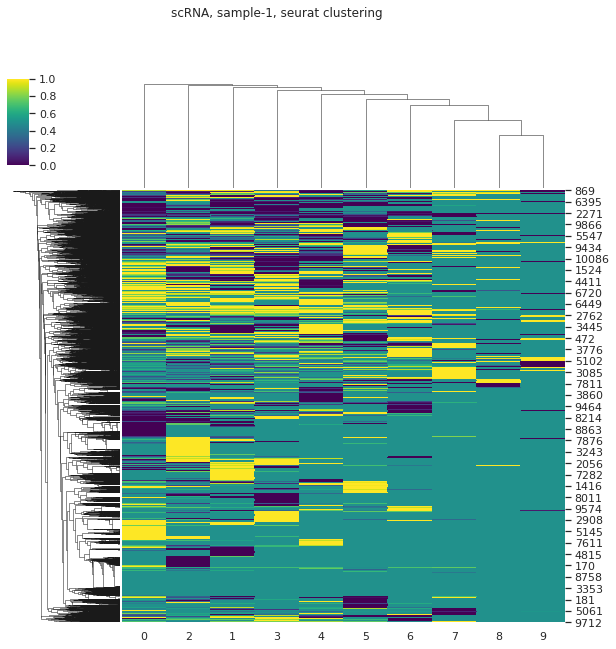

In [7]:
ase.plot_ase(
    ase_df=ase.compute_ase(clustered_scRNA_counts_df, 
                           mbtools.extract_barcodes(clustered_scRNA_counts_df)),
    row_cluster=True,
    title="scRNA, sample-1, seurat clustering",
)

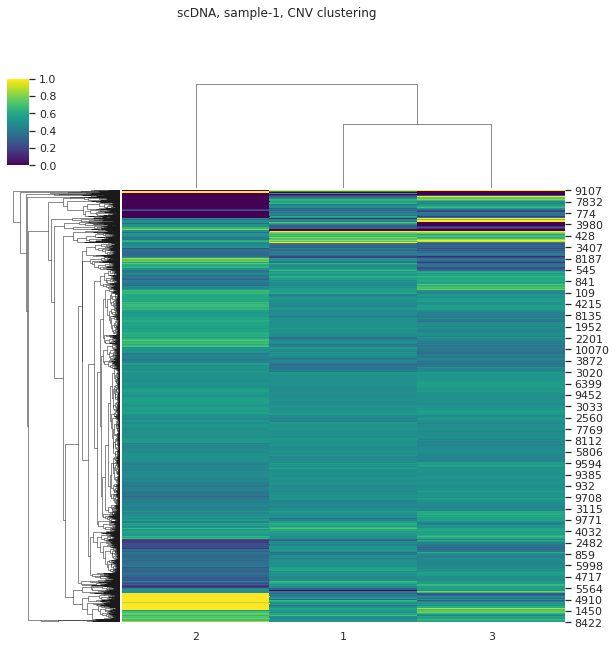

In [8]:
ase.plot_ase(
    ase_df=ase_info["scDNA"].drop(columns=["GENE_ID"]),
    row_cluster=True,
    title="scDNA, sample-1, CNV clustering"
)


CPU times: user 372 ms, sys: 89.6 ms, total: 462 ms
Wall time: 357 ms


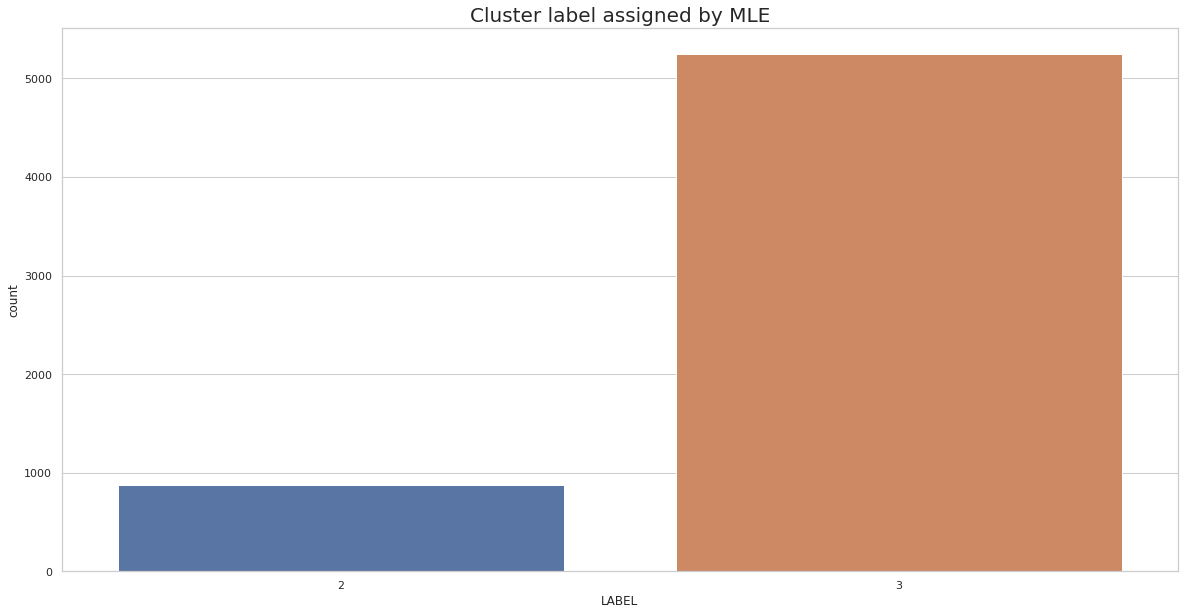

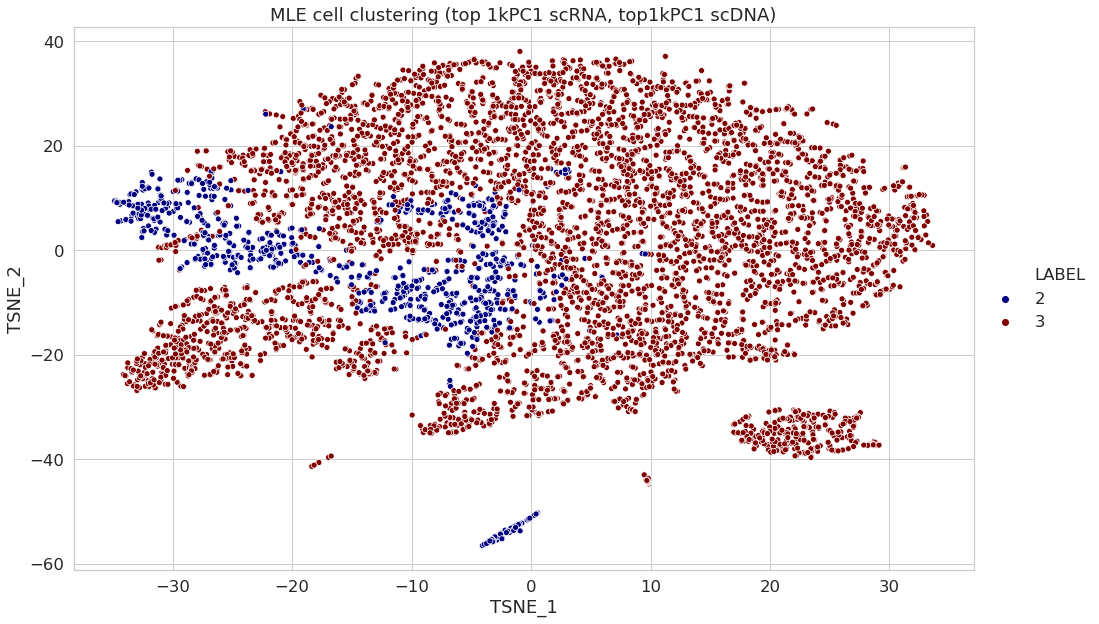

In [44]:
%%time
clf = cnv_inference.AseMleClassifier(
    clustering_info['scDNA'], 
    clustering_info['scRNA']
)

labels = clf.predict(
    clustered_scRNA_counts_df, 
    ase_info["scDNA"]
)

clf.classification_report(
    clustering_info["scRNA"].LABEL.apply(lambda i: labels[i] + 1), 
    "MLE cell clustering (top 1kPC1 scRNA, top1kPC1 scDNA)"
)

# Simulations

In [54]:
"""
This class samples cells from binomial model specified by ASE profiles.
Currently, inference of ASE profile is guided by clustering information:
read counts are added up in each cluster and ASE profiles are computed
for those clusters instead of individual cells.
To sample one cell, the toolkit generates some number of "pseudocells", 
vectors of gene expression counts with a fraction of missing values 
bounded from above by some prespecified constant. Those counts are then 
added up to make up an ASE profile of each sampled cell. 
"""
from typing import Dict, List, Iterable, Callable
import scipy.stats as sps

class AseSampler: 
    def __init__(
        self, 
        # dict of phased read counts
        counts_info: Dict[str, pd.DataFrame],
        # dict with a priori clustering information
        clustering_info: Dict[str, pd.DataFrame], 
        # number of jobs to spawn for parallel processing
        n_jobs: int = max(mp.cpu_count() // 2, 1),
        # verbosity flag
        verbose: bool = False
    ): 
        
        assert sorted(counts_info.keys()) == sorted(clustering_info.keys()),\
                "Key sets of counts_info and clustering_info do not match.\n"\
                f"counts_info: {counts_info.keys()}\n"\
                f"clustering_info: {clustering_info.keys()}"
        
        assert "scDNA" in counts_info.keys()
        
        for data_type in clustering_info.keys():
            counts_df = counts_info[data_type]
            clustering_df = clustering_info[data_type]
            
            assert mbutil.is_sorted(counts_df.index)\
                and mbutil.is_sorted(clustering_df.index),\
                f"Index not sorted for {data_type}"
            
            assert "GENE_ID" in counts_df.columns,\
                    f"No GENE_ID column in counts_info for {data_type}"
            
            assert np.all(np.isin(["BARCODE", "LABEL"], 
                                  clustering_df.columns)),\
                    f"BARCODE or LABEL columns not specified for {data_type}"
        
            assert np.all(mbtools.extract_barcodes(counts_df) 
                          == clustering_df.BARCODE),\
                    "No cluster label provided for some of the barcodes"
            
#         assert np.all(counts_info["scDNA"].GENE_ID 
#                       == counts_info["scRNA"].GENE_ID),\
#                 "GENE_ID in scDNA and scRNA differ"
        self._gene_ids = counts_info["scDNA"].GENE_ID
        self._counts_info = counts_info
        self._clustering_info = clustering_info
        
        self._clustered_counts_info = {}
        for data_type, counts_df in counts_info.items():
            self._clustered_counts_info[data_type] =\
                mbtools.aggregate_by_barcode_groups(
                    counts_df,
                    clustering_info[data_type]
                )
        
        self._errstream = sys.stdout if verbose else open(os.devnull, "w+")
        
        assert n_jobs > 0, f"Incorrect n_jobs value: {n_jobs}"
        self._n_jobs = n_jobs

        
    def _sample_pseudocells(
        self, 
        counts_ad_profile: np.ndarray, # ints; n
        counts_dp_profile: np.ndarray, # ints; n
        nan_fraction: float, 
        n_pseudo_per_cell: int
    ): 
        
        # Sample read counts from binomial model.
        # Also take care of the missing values:
        # if no reads map to a specific gene after
        # read counts in each cluster are added up,
        # it should be discarded from the simulation. 
        # Nevertheless, pseudocells should have the
        # same dimensions as the real cells, so the 
        # discarded positions should be added back after sampling.
        
        assert counts_ad_profile.shape == counts_dp_profile.shape,\
                "Count profiles are not aligned"
        
        pseudocell_info = defaultdict(list)
        for i in range(n_pseudo_per_cell):
            old_ad_profile = counts_ad_profile.copy()
            old_dp_profile = counts_dp_profile.copy()

            old_nan_mask = np.isnan(counts_dp_profile)
            old_nan_fraction = old_nan_mask.mean()
            old_nan_count = old_nan_mask.sum()

            if old_nan_fraction < nan_fraction:
    #             print("BEFORE:", np.isnan(counts_dp_profile).mean())
                indices = np.arange(counts_dp_profile.size)
                expected_nan_count = np.ceil(
                    nan_fraction * counts_dp_profile.size
                ).astype(int)
    #             print(expected_nan_count, true_nan_count)
                new_nan_pos = np.random.choice(
                    indices[~old_nan_mask],
                    expected_nan_count - old_nan_count,
                    replace=False
                )
                new_nan_mask = np.isin(indices, new_nan_pos)
                counts_dp_profile[new_nan_mask] = np.nan
                counts_ad_profile[new_nan_mask] = np.nan
    #             print("AFTER:", np.isnan(counts_dp_profile).mean())

            ase_profile = counts_ad_profile / counts_dp_profile
            ase_profile[np.isnan(ase_profile)] = 0.5

            n_genes = ase_profile.size
            model = sps.binom(
                n=np.nan_to_num(counts_dp_profile).astype(np.int64),
                p=ase_profile
            )
            pseudocell_info["ad"].append(model.rvs((1, n_genes)).T)
            pseudocell_info["dp"].append(counts_dp_profile)
            
            counts_ad_profile = old_ad_profile
            counts_dp_profile = old_dp_profile
            
        pseudocell_info = {
            counts_type : 
            np.column_stack(pseudocell_list)
            for counts_type, pseudocell_list
            in pseudocell_info.items()
        }
        for counts_type in ["ad", "dp"]:
            pseudocell_mx = pseudocell_info[counts_type]
            assert pseudocell_mx.shape == (n_genes, n_pseudo_per_cell),\
                    "Malformed matrix of pseudocells.\n"\
                    " Expected shape of {}, got {}".format(
                (n_genes, n_pseudo_per_cell),
                pseudocell_mx.shape
            )
        return pseudocell_info # n x n_pseudo_per_cell

    
    def _sample_cell(
        self, 
        counts_ad_profile: np.ndarray, 
        counts_dp_profile: np.ndarray, 
        nan_fraction: float,
        n_pseudo_per_cell: int
    ): 
        
        inferred_counts_info = {
            counts_type :
            np.full_like(counts_dp_profile, np.nan)
            for counts_type in ["ad", "dp"]
        }
        pseudocell_info = self._sample_pseudocells(
            counts_ad_profile.copy(),
            counts_dp_profile.copy(),
            nan_fraction,
            n_pseudo_per_cell
        )
        for counts_type in ["ad", "dp"]:
            notnan_mask = np.invert(
                np.array([
                    np.all(np.isnan(gene_row))
                    for gene_row in pseudocell_info["dp"]
                ])
            )
            inferred_counts_info[counts_type][notnan_mask] = np.nansum(
                pseudocell_info[counts_type][notnan_mask, :], 
                axis=1
            )
        
        return inferred_counts_info
     
    
    def sample(self, n_cells_per_cluster, nan_fraction, n_pseudo_per_cell): 
        assert 0 <= nan_fraction <= 1,\
            f"nan_fraction outside [0, 1]: {nan_fraction}"
        
        assert n_pseudo_per_cell > 0,\
            "Need at least one pseudocell to sample a cell!\n"\
            f"Passed: {n_pseudo_per_cell}"  
        
        sampled_counts_df_list = []
        
        # which loop to parallelize?
        # this one or the nested one?
        for cluster_label in tqdm_notebook(
            mbtools.extract_barcodes(self._clustered_counts_info["scDNA"]), 
            desc="generating cells from scDNA clusters"
        ):
            sampled_counts_list = []
            counts_ad_profile = self._clustered_counts_info["scDNA"]\
                                    [f"{cluster_label}_ad"].copy().values
            counts_dp_profile = self._clustered_counts_info["scDNA"]\
                                    [f"{cluster_label}_dp"].copy().values
                
            # this loop can be parallelized 
            # it's body should become a separate function
            for i in tqdm_notebook(
                range(n_cells_per_cluster), 
                desc=f"sampling fake cells from cluster {cluster_label}"
            ):
                
                sampled_cell_info = self._sample_cell(
                    counts_ad_profile,
                    counts_dp_profile, 
                    nan_fraction,
                    n_pseudo_per_cell
                )
                sampled_counts_list.append(sampled_cell_info)
                
            sampled_counts_df_list.append(
                pd.DataFrame(
                    np.column_stack([
                        np.column_stack([
                            cell_info[counts_type]
                            for counts_type in ["ad", "dp"]
                        ])
                        for cell_info in sampled_counts_list
                    ]),
                    columns=np.hstack([
                        [f"{cluster_label}_{i}_ad", 
                         f"{cluster_label}_{i}_dp"]
                        for i in range(n_cells_per_cluster)
                    ])
                )
            )
            
        sampled_counts_df = pd.concat(sampled_counts_df_list, axis=1)
        sampled_counts_df.insert(0, "GENE_ID", self._gene_ids)
        return sampled_counts_df

In [55]:
sampler = AseSampler(
    {"scDNA" : counts_info["scDNA"]}, 
    {"scDNA" : clustering_info["scDNA"]}
)

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide


Per column:
GENE_ID    0.000000
1_0_ad     0.773701
1_0_dp     0.773701
1_1_ad     0.775951
1_1_dp     0.775951
             ...   
3_27_dp    0.775364
3_28_ad    0.777321
3_28_dp    0.777321
3_29_ad    0.772527
3_29_dp    0.772527
Length: 181, dtype: float64
Per row:
0        0.718232
1        0.806630
2        0.795580
3        0.762431
4        0.817680
           ...   
10216    0.729282
10217    0.795580
10218    0.795580
10219    0.806630
10220    0.817680
Length: 10221, dtype: float64
In total:  0.7700114756694726


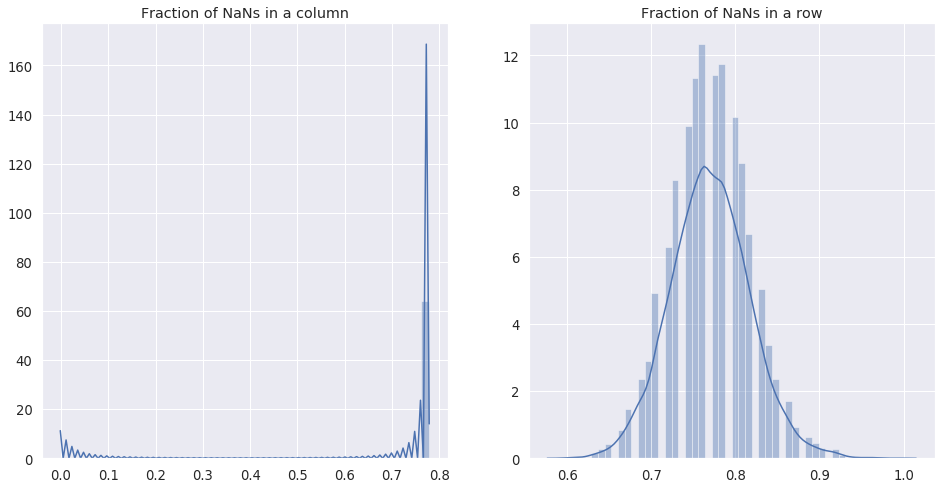

In [71]:
sample = sampler.sample(
    n_cells_per_cluster=30, 
    nan_fraction=0.95, 
    n_pseudo_per_cell=5
)
mbutil.nan_fraction(
    sample, axis_list=[0,1], 
    show_plots=True, verbose=True
);

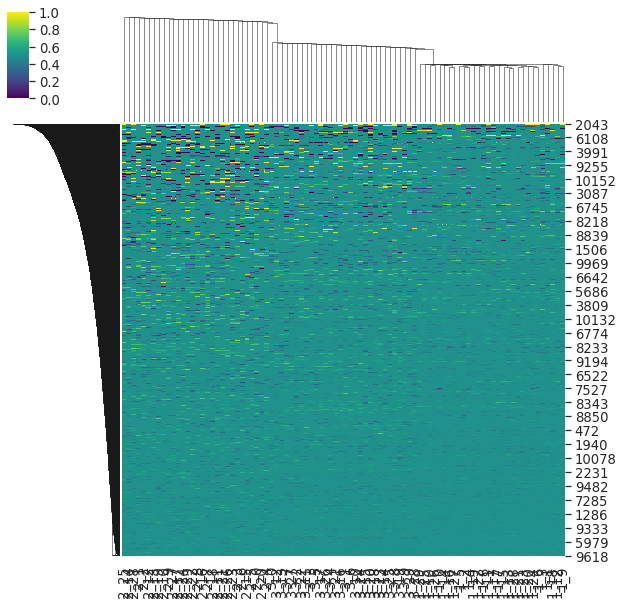

In [76]:
sys.setrecursionlimit(10000)
ase.plot_ase(
    ase.compute_ase(sample, mbtools.extract_barcodes(sample)), 
    row_cluster=True
)

In [79]:
%%time
clf = cnv_inference.AseMleClassifier(
    clustering_info['scDNA'], 
    clustering_info['scRNA']
)

labels = clf.predict(
    sample, 
    ase_info["scDNA"]
) + 1

# clf.classification_report(
#     clustering_info["scRNA"].LABEL.apply(lambda i: labels[i] + 1), 
#     "MLE cell clustering (top 1kPC1 scRNA, top1kPC1 scDNA)"
# )

CPU times: user 1.6 s, sys: 70.8 ms, total: 1.67 s
Wall time: 1.64 s


In [80]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])